Melissa Graham, Fri Oct 25 <br>
This notebook is a demonstration of (a simple but wrong way to do) interpolation.

In [1]:
### Import needed packages
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d

In [2]:
### Read the photo-z results into numpy arrays (like we did with example_read_grid_data.ipynb).
### Limiting magnitudes in ugrizy from the first six columns
maglims = np.loadtxt( 'grid_stddevs.dat', dtype='float', usecols=(0,1,2,3,4,5))
### Standard deviation in lowest redshift bin from the 7th column
values = np.loadtxt( 'grid_stddevs.dat', dtype='float', usecols={6})

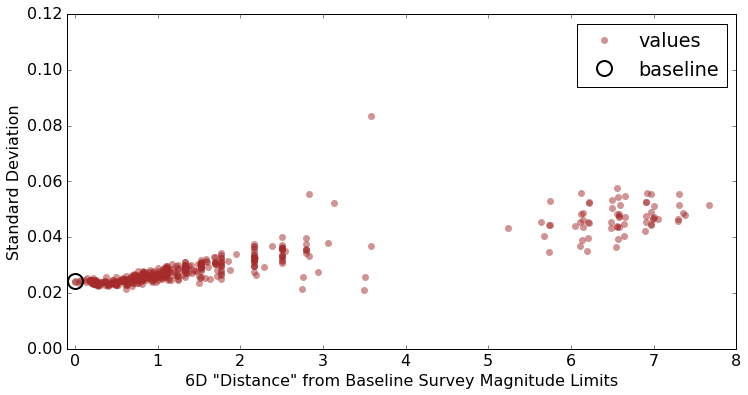

In [3]:
### Plot the standard deviation as a function of the 6-dimensional "distance" of each
### run's limiting magnitudes from the baseline (like we did with example_read_grid_data.ipynb).
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size':16})
dist6d = np.zeros( maglims.shape[0], dtype='float' )
for i in range(maglims.shape[0]):
    for j in range(maglims.shape[1]):
        dist6d[i] += (maglims[i][j] - maglims[0][j])**2
    dist6d[i] = np.sqrt(dist6d[i])
plt.plot(dist6d, values, 'o', ms=7, alpha=0.5, mew=0, color='brown', label='values')
plt.plot(0.0, values[0], 'o', ms=15, alpha=1.0, mew=2, color='black', fillstyle='none', label='baseline')
plt.xlabel('6D "Distance" from Baseline Survey Magnitude Limits')
plt.ylabel('Standard Deviation')
plt.legend(loc='best',numpoints=1)
plt.xlim([-0.1,8])
plt.ylim([0.0,0.12])
plt.show()

<br><br><br>
We want to use the data we have, and estimate the standard deviation in photo-z results that would <br>
be delivered by an LSST observing strategy which provides a given set of 10-year limiting magnitudes.

In [4]:
### Define a set of limiting magnitudes to use for this example
test_maglims = np.asarray( [26.0, 26.0, 26.0, 26.0, 26.0, 24.0], dtype='float' )

### Calculate the "distance" in 6-d
test_dist6d = np.zeros( 1, dtype='float' )
for j in range(maglims.shape[1]):
    test_dist6d += (test_maglims[j] - maglims[0][j])**2
test_dist6d = np.sqrt(test_dist6d)

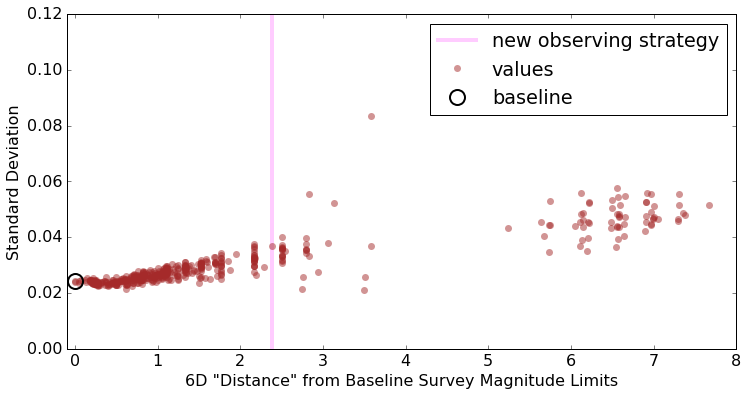

In [5]:
### Put this new survey strategy's limiting magnitudes in context with our data
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size':16})

### plot a vertical line at the position we'd like to interpolate
plt.axvline(test_dist6d, color='magenta', lw=4, alpha=0.2, label='new observing strategy')

plt.plot(dist6d, values, 'o', ms=7, alpha=0.5, mew=0, color='brown', label='values')
plt.plot(0.0, values[0], 'o', ms=15, alpha=1.0, mew=2, color='black', fillstyle='none', label='baseline')
plt.xlabel('6D "Distance" from Baseline Survey Magnitude Limits')
plt.ylabel('Standard Deviation')
plt.legend(loc='best',numpoints=1)
plt.xlim([-0.1,8])
plt.ylim([0.0,0.12])
plt.show()

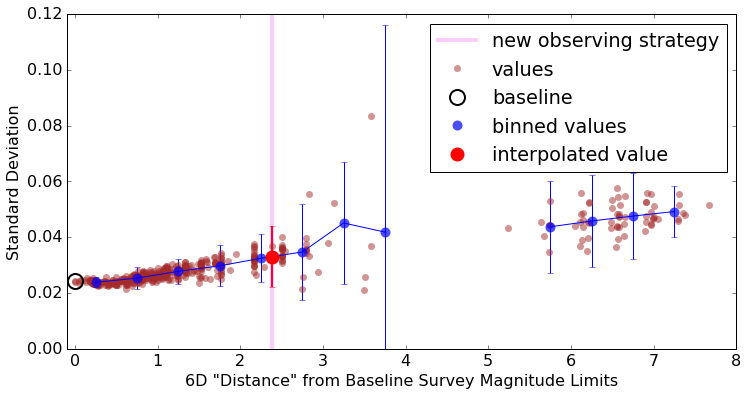

In [6]:
### An easy (but incorrect) way to interpolate is to bin the data and use scipy.interpolate.interp1d:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size':16})
plt.axvline(test_dist6d, color='magenta', lw=4, alpha=0.2, label='new observing strategy')
plt.plot(dist6d, values, 'o', ms=7, alpha=0.5, mew=0, color='brown', label='values')
plt.plot(0.0, values[0], 'o', ms=15, alpha=1.0, mew=2, color='black', fillstyle='none', label='baseline')

### bin the values and plot the bin values with 3-sigma errors in blue
bin_centers = np.arange( 16, dtype='float' )*0.5 +0.25
bin_values = np.zeros( 16, dtype='float' )
bin_valerr = np.zeros( 16, dtype='float' )
for b,bc in enumerate(bin_centers):
    ### Find all values points in this bin
    tx = np.where( (dist6d >= bc-0.25) & (dist6d < bc+0.25) )[0]
    if len(tx) > 1:
        bin_values[b] = np.mean(values[tx])
        bin_valerr[b] = np.std(values[tx])
    else:
        bin_values[b] = float('NaN')
        bin_valerr[b] = float('NaN')
plt.errorbar(bin_centers, bin_values, 3.0*bin_valerr, color='blue')
plt.plot(bin_centers, bin_values, 'o', ms=10, alpha=0.7, mew=0, color='blue', label='binned values')

### interpolte the values and the error at our desired set of limiting magnitudes
function_interp_values = interp1d(bin_centers, bin_values)
function_interp_valerr = interp1d(bin_centers, bin_valerr)
test_value  = function_interp_values(test_dist6d)
test_valerr = function_interp_valerr(test_dist6d)
plt.errorbar(test_dist6d, test_value, 3.0*test_valerr, color='red', lw=2)
plt.plot(test_dist6d, test_value, 'o', ms=14, alpha=1, mew=0, color='red', label='interpolated value')


plt.xlabel('6D "Distance" from Baseline Survey Magnitude Limits')
plt.ylabel('Standard Deviation')
plt.legend(loc='best',numpoints=1)
plt.xlim([-0.1,8])
plt.ylim([0.0,0.12])
plt.show()

<br><br><br>
Why is this wrong? <br>

The main reason is that we have lost a lot of information about how the standard deviation in <br>
photo-z results changes with the limiting magnitudes by reducing the correlation from six to <br>
two dimensions by using the 6D "Distance" from the baseline. <br>
As we saw in Graham+19, some filters have more influence on the photo-z results than others. <br>
A change in only the u- or r-band by 1 magnitude would result in the same value of "dist6d", <br>
but have very different photo-z results and thus different standard deviations. <br>
So we have to keep the information about which filters have change in depth. <br>
<br>
Also I think to simply interpolate the errors is statistically the incorrect way to do that... <br>
<br>
Time to move to the next notebook example_6d_interpolation.ipynb. <br>